In [1]:
# Libraries to be used 
import pandas as pd
import numpy as np
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
%matplotlib inline
sns.set(color_codes=True)

In [2]:
# Import the file into a dataframe 

try:
    aps_failure_set=pd.read_csv(r"\\sedna\jokin.ormazabal$\$Profile\Desktop\Master\Data Prep\aps_failure_set.csv")
    print("APS Failure Set successfully imported into a dataframe")
except:
    print("Something went wrong importing the APS Failure Set")

#As comma is the defaulted delimiter, we dont need to specify it

#try to do it trough a url (desde github?? ) / lo he encontrado en kaggel


APS Failure Set successfully imported into a dataframe


## Analyze the context of the dataset

In [3]:
aps_failure_set.head(5)

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [4]:
aps_failure_set.shape

(60000, 171)

In [5]:
Per_APS=str(round(aps_failure_set['class'].value_counts()['pos']/60000,2)*100) 
Per_NotAPS=str(round(aps_failure_set['class'].value_counts()['neg']/60000,2)*100)

# They need to be in string format even there are numbers to be able to concatenate them latter


C:\Users\jokin.ormazabal\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


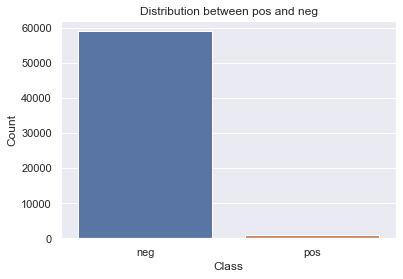

2.0% of the trucks have issues related to the APS system
98.0% of the trucks have issues NOT related to the APS system


In [6]:
sns.barplot(aps_failure_set['class'].unique(),aps_failure_set['class'].value_counts())
plt.title('Distribution between pos and neg')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show() # I show first the plot, so the statements fall below for a better view

print(Per_APS + '%'+' of the trucks have issues related to the APS system')
print(Per_NotAPS + '%'+' of the trucks have issues NOT related to the APS system')

#### Looking at the explanation provided and the shape of the dataframe, each cell of the dataset contains the number of errors flagged by each of the 170 sensors for 6000 trucks. This is also tagged by failures regarding the APS (POS) and not (NEG). In this analysis I will illustrate which of those sensors are more likely to predict an error correlated with a failure on the APS system.

### EXPLANATORY DATA ANALYSIS FOR APS RELATED FAILURES

##### NULL VALUES

In [7]:
aps_failures=aps_failure_set.loc[aps_failure_set['class']=='pos'] # Select only the trucks with APS failures

aps_failures=aps_failures.drop(['class'],axis=1) # Drop the column class as its a string and doesnt provide any relevant information

In [8]:
if aps_failures.isnull().sum().any():
    print("The dataframe has nulls")
else:
    print("The dataframe has not nulls")

The dataframe has not nulls


We know by looking at the data that it actually has na values but the function is not catching them.
This happens because the na is a string and for python the value is actually not null. To avoid this I will replace the na value for null values that follow the expected format by numpy library
It is important to always manually review the data and check that the output from the code make sense.

In [9]:
aps_failures=aps_failures.replace("na",np.nan) 

if aps_failures.isnull().sum().any():
    print("The dataframe has nulls")
else:
    print("The dataframe has not nulls")

The dataframe has nulls


As expected, the data has null values, so now It will interesting to see the % of nulls by sensor type

In [10]:
aps_failures.shape


(1000, 170)

In [11]:
null_percentages=(aps_failures.isnull().sum()/1000*100)

In [12]:
High_null_aps_failures = pd.DataFrame(null_percentages, columns=['High_Null']) #Data frame with the % of null values by column
print (High_null_aps_failures)

        High_Null
aa_000        0.0
ab_000       77.1
ac_000       46.2
ad_000       64.5
ae_000       34.1
...           ...
ee_007        0.5
ee_008        0.5
ee_009        0.5
ef_000       37.7
eg_000       37.7

[170 rows x 1 columns]


In [13]:
High_null_aps_failures.reset_index(drop=False, inplace=True) #I need to add an index as the sensor names where not counting as a propper column

In [14]:
High_null_aps_failures=High_null_aps_failures[High_null_aps_failures.iloc[:,1]>20] #Select the sensors with greater than 20% null values

High_null_aps_failures.head(5)

,index,High_Null
1,ab_000,77.1
2,ac_000,46.2
3,ad_000,64.5
4,ae_000,34.1
5,af_000,34.1


In [15]:
High_null_aps_failures.shape

(60, 2)

There are 60 sensors flagging no data 20% or more times. As I still have 110 sensors, I will eliminate those sensors and tag them as faulty sensors.

In [16]:
faulty_sensors_aps=High_null_aps_failures.iloc[:,0].tolist() #get the name of the faulty sensors on a list 

aps_failures=aps_failures.drop(faulty_sensors_aps,axis=1)
aps_failures.shape

(1000, 110)

We droped what I considered faulty sensors by the high null values, but still we have nulls on the other sensors.
The existance of this nulls makes the sample inconsistant as we have more records for some sensors. 
We will drop the rows with null values to make the data set equal for every sensor type.

In [17]:
aps_failures = aps_failures.dropna()
aps_failures.shape

(861, 110)

We have cleaned our dataset from nulls and "faulty" data
The next step for a data normalization is to identify and remove the outliers.

##### OUTLIERS

Outliers are data points that dont follow the normal distribution of the variable, they are vastly high or low. To visualize this I will do a box plot for sensor bb_000; outliers are the points that fall outside of the box. 

In [18]:
aps_failures=aps_failures.astype(float) # Convert all the df to float type. It got converted to int with so many cleaning


<AxesSubplot:xlabel='bb_000'>

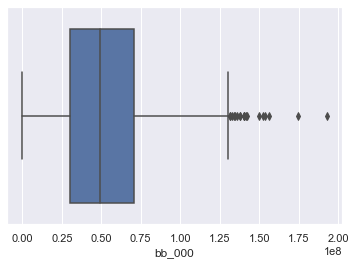

In [19]:
sns.boxplot(x=aps_failures['bb_000']) 

In [20]:
#Indentify and remove outliers

Q1 = aps_failures.quantile(0.25)
Q3 = aps_failures.quantile(0.75)
IQR = Q3 - Q1
print(IQR) 


aa_000     605760.0
ag_000          0.0
ag_001       7824.0
ag_002     379654.0
ag_003    3997910.0
            ...    
ee_005    5859046.0
ee_006    5052078.0
ee_007    2906890.0
ee_008     506452.0
ee_009       2118.0
Length: 110, dtype: float64


In [21]:
aps_failures = aps_failures[~((aps_failures < (Q1 - 1.5 * IQR)) |(aps_failures > (Q3 + 1.5 * IQR))).any(axis=1)]
aps_failures.shape 


(61, 110)

<AxesSubplot:xlabel='bb_000'>

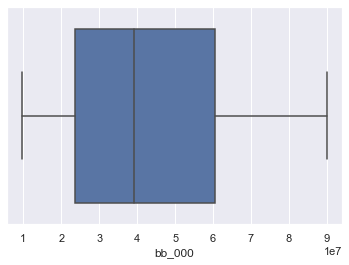

In [22]:
sns.boxplot(x=aps_failures['bb_000']) 

As we can see on the new graph, the outliers have been removed.

We have explained the context of the data received and cleaned it from any nulls, missing data, faulty sensors and outliers. This exercise has decreased our sample significantly from 1000 rows to 61 but o the other hand, I have now high quality data to rely on and use for predictions. 

##### GET THE MEAN AND SELECT THE MOST RELEVANT SENSORS

In [23]:
aps_failures.loc['mean'] = aps_failures.mean() # Add a row with the mean of errors for each sensor

In [24]:
aps_failures

,aa_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,...,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009
1517,8.163160e+05,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
2112,2.984180e+05,0.0,16532.000000,185432.000000,2.527400e+06,5.108956e+06,5.448306e+06,2.988024e+06,7.591540e+05,155052.000000,...,2.418204e+06,1.827344e+06,1.405826e+06,4.801780e+05,1.176638e+06,2.430398e+06,2.377636e+06,5.006194e+06,66434.000000,0.000000
2691,1.047110e+06,0.0,0.000000,0.000000,1.213944e+06,9.201056e+06,1.337203e+07,4.445804e+06,5.870660e+05,27592.000000,...,6.093502e+06,3.428036e+06,2.329436e+06,1.014358e+06,1.817662e+06,2.116664e+06,5.138200e+06,6.671862e+06,237756.000000,16.000000
3343,1.814600e+05,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
5109,1.337140e+05,0.0,0.000000,0.000000,6.000000e+00,1.978500e+05,5.128174e+06,9.443334e+06,4.040410e+06,256934.000000,...,4.604576e+06,9.568076e+06,2.631806e+06,6.980400e+05,1.142032e+06,4.040880e+05,1.444400e+04,2.566000e+03,1606.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57495,5.415300e+05,0.0,9836.000000,476728.000000,5.066604e+06,1.150504e+07,1.189928e+07,4.158110e+06,2.274320e+05,22782.000000,...,5.170866e+06,3.766774e+06,2.786194e+06,1.516780e+06,3.906754e+06,7.229264e+06,8.038736e+06,8.729320e+05,81848.000000,56.000000
58101,1.318664e+06,0.0,0.000000,79314.000000,2.708806e+06,8.418038e+06,7.568058e+06,2.106910e+06,5.491200e+04,176.000000,...,2.473802e+06,2.848560e+06,1.501432e+06,5.871820e+05,1.277140e+06,3.266630e+06,6.084454e+06,2.819216e+06,77446.000000,352.000000
58885,3.966900e+05,0.0,0.000000,0.000000,2.780000e+03,5.213620e+05,5.701268e+06,1.399475e+07,4.013454e+06,8740.000000,...,1.902146e+06,3.953116e+06,3.695016e+06,1.897532e+06,4.212994e+06,3.928426e+06,2.852630e+06,1.102338e+06,696712.000000,1446.000000
59274,1.814600e+05,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000


In [25]:
aps_failures=aps_failures.transpose() # to put the sensors as rows and select top 5
top_aps_failures=aps_failures['mean'].nlargest(n=5)

In [26]:
top_aps_failures=pd.DataFrame(top_aps_failures) # Create a new dataframe with only the top 5 sensors
top_aps_failures = top_aps_failures.reset_index()
top_aps_failures=top_aps_failures.rename(columns={'index':'Sensor name'})

In [27]:
top_aps_failures

,Sensor name,mean
0,bb_000,4.192948e+07
1,bv_000,4.192948e+07
2,cq_000,4.192948e+07
3,bu_000,4.192948e+07
4,ci_000,3.082174e+07


In [28]:
top_aps_failures_list=top_aps_failures.iloc[:,0].tolist() #get the name of top sensors on a list 

In [29]:
aps_failures=aps_failures.drop(['mean'],axis=1) # Drop the mean to exclude it from the total count

In [30]:
aps_failures=aps_failures.transpose() #if I dont transpose it it doesnt let me get the sensors on a list 
top_aps_failures=aps_failures[top_aps_failures_list]

In [31]:
sum = top_aps_failures.sum()
sum.name = 'Sum'
top_aps_failures = top_aps_failures.append(sum.transpose()) #add a total value row

<ipython-input-31-151c78f1bd7d>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_aps_failures = top_aps_failures.append(sum.transpose()) #add a total value row


In [32]:
top_aps_failures=top_aps_failures.transpose()

In [33]:
top_aps_failures=top_aps_failures['Sum']
top_aps_failures=pd.DataFrame(top_aps_failures)

In [34]:
top_aps_failures

,Sum
bb_000,2.557698e+09
bv_000,2.557698e+09
cq_000,2.557698e+09
bu_000,2.557698e+09
ci_000,1.880126e+09


Text(0.5, 0, 'Sensor Names')

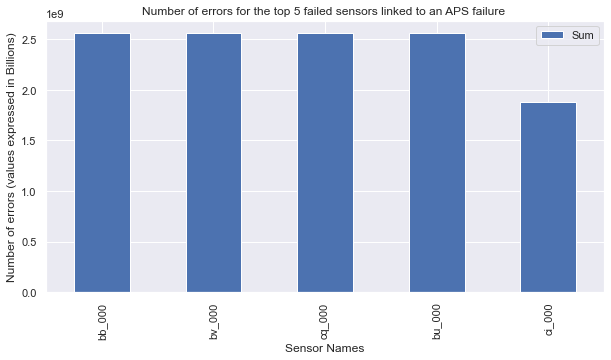

In [35]:
top_aps_failures.plot(kind='bar', figsize=(10,5))
plt.title('Number of errors for the top 5 failed sensors linked to an APS failure ')
plt.ylabel('Number of errors (values expressed in Billions)')
plt.xlabel('Sensor Names')

Get the % of the total errors flagged by these 5 sensors.

In [36]:

sum = aps_failures.sum()
sum.name = 'sum'
aps_failures = aps_failures.append(sum.transpose()) #add a total value row

aps_failures=aps_failures.transpose()

total_errors = aps_failures['sum'].sum()

total_errors=str(total_errors)

<ipython-input-36-35bef56251dc>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aps_failures = aps_failures.append(sum.transpose()) #add a total value row


In [37]:
print('There are a total of ' + total_errors + ' errors')

There are a total of 26709517835.13 errors


In [38]:
total_errors=float(total_errors)

top_aps_failures
top_aps_failures=top_aps_failures.rename(columns={'Sum':'number_of_errors'})
top_aps_failures['%_of_total_errors'] = (top_aps_failures['number_of_errors'] / total_errors) * 100

In [39]:
top_aps_failures

,number_of_errors,%_of_total_errors
bb_000,2.557698e+09,9.575980
bv_000,2.557698e+09,9.575980
cq_000,2.557698e+09,9.575980
bu_000,2.557698e+09,9.575980
ci_000,1.880126e+09,7.039161


In [40]:
top_sensors_errors_per = top_aps_failures['%_of_total_errors'].sum()
top_sensors_errors_per=str(round(top_sensors_errors_per,2))


In [41]:
print (top_sensors_errors_per + '% of errors are flagged by the top 5 sensors')

45.34% of errors are flagged by the top 5 sensors


##### Conclusions for the APS related failures

    - From the 6000 analyzed trucks, only 2.0% of them had an APS related failure
    - 60 out of 170 were considered failed sensors because 20% or more than their results were null (35%)
    - After cleaning and normalizing the data 62 rows were tooked into account which reduces the sample by a lot but makes             our data more reliable.
    - 5 sensors flag 45.34% of the errors for trucks with a known APS failure


### EXPLANATORY DATA ANALYSIS FOR NOT APS RELATED FAILURES

I'll apply the same analysis for the not APS related failures

In [42]:
not_aps_failures=aps_failure_set.loc[aps_failure_set['class']=='neg'] 

not_aps_failures=not_aps_failures.drop(['class'],axis=1)

##### NULL, DUPLICATED & MISSING VALUES 

In [43]:
#not_aps_failures = not_aps_failures[not_aps_failures.duplicated()]

In [44]:
not_aps_failures=not_aps_failures.replace("na",np.nan) 

if not_aps_failures.isnull().sum().any():
    print("The dataframe has nulls")
else:
    print("The dataframe has not nulls")

The dataframe has nulls


In [45]:
not_aps_failures.shape

(59000, 170)

In [46]:
null_percentages=(not_aps_failures.isnull().sum()/5900*100)
High_null_not_aps_failures = pd.DataFrame(null_percentages, columns=['High_Null']) #Data frame with the % of null values by column
High_null_not_aps_failures.reset_index(drop=False, inplace=True)


In [47]:
High_null_not_aps_failures=High_null_not_aps_failures[High_null_not_aps_failures.iloc[:,1]>20] #Select the sensors with greater than 20% null values

High_null_not_aps_failures.head(5)

,index,High_Null
1,ab_000,772.169492
2,ac_000,48.694915
3,ad_000,240.949153
4,ae_000,36.593220
5,af_000,36.593220


In [48]:
High_null_aps_failures.shape

(60, 2)

As on the other case, we have 60 sensors that trigger a high percentage of Nulls. It will be interesting to see if they are the same, but this will be analyze latter, when I merge both variables. For now, I'll treat them as faulty sensors 

In [49]:
faulty_sensors_not_aps=High_null_aps_failures.iloc[:,0].tolist() #get the name of the faulty sensors on a list 

not_aps_failures=not_aps_failures.drop(faulty_sensors_not_aps,axis=1)
not_aps_failures.shape

(59000, 110)

##### Drop the nulls

In [50]:
not_aps_failures = not_aps_failures.dropna()
not_aps_failures.shape

(6905, 110)

##### OUTLIERS

<AxesSubplot:xlabel='aa_000'>

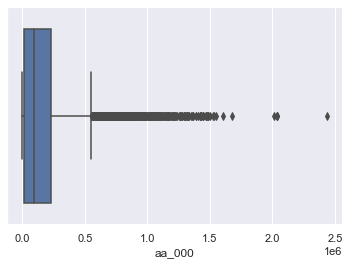

In [51]:
not_aps_failures=not_aps_failures.astype(float) 
sns.boxplot(x=not_aps_failures['aa_000']) 

In [52]:
Q1 = not_aps_failures.quantile(0.25)
Q3 = not_aps_failures.quantile(0.75)
IQR = Q3 - Q1
print(IQR) 

aa_000     216998.0
ag_000          0.0
ag_001          0.0
ag_002          0.0
ag_003      14596.0
            ...    
ee_005    1121454.0
ee_006    1095204.0
ee_007     786352.0
ee_008     253258.0
ee_009       3244.0
Length: 110, dtype: float64


In [53]:
not_aps_failures = not_aps_failures[~((not_aps_failures < (Q1 - 1.5 * IQR)) |(not_aps_failures > (Q3 + 1.5 * IQR))).any(axis=1)]
not_aps_failures.shape 

(1484, 110)

<AxesSubplot:xlabel='aa_000'>

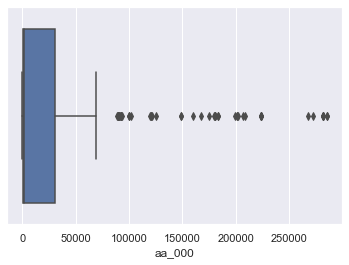

In [54]:
sns.boxplot(x=not_aps_failures['aa_000']) 

As, we can see on this graph, not all the outliers have been removed; I could re-run the code again until I remove all of them, but for similarity with the analysis of the other variable I will mantain those. The code above removes everything below the first Quartile (Q1) or above the third Quartile (Q3) so any residual outliers wont have an impact on the conclusions

We have explained the context of the data received and cleaned it from any nulls, missing data, faulty sensors and outliers. This exercise has decreased our sample significantly from 5900 rows to 1484 but on the other hand, I have now high quality data to rely on and use for predictions.

##### GET THE MEAN AND SELECT THE MOST RELEVANT SENSORS

In [55]:
not_aps_failures.loc['mean'] = not_aps_failures.mean() # Add a row with the mean of errors for each sensor

In [56]:
not_aps_failures.loc['mean'] = not_aps_failures.mean() # Add a row with the mean of errors for each sensor
not_aps_failures=not_aps_failures.transpose()
top_not_aps_failures=not_aps_failures['mean'].nlargest(n=5)

In [57]:
top_not_aps_failures=pd.DataFrame(top_not_aps_failures) # Create a new dataframe with only the top 5 sensors
top_not_aps_failures = top_not_aps_failures.reset_index()
top_not_aps_failures=top_not_aps_failures.rename(columns={'index':'Sensor name'})

In [58]:
top_not_aps_failures

,Sensor name,mean
0,bb_000,1.296880e+06
1,bu_000,1.296880e+06
2,bv_000,1.296880e+06
3,cq_000,1.296880e+06
4,br_000,1.284859e+06


In [59]:
top_not_aps_failures=top_not_aps_failures.iloc[:,0].tolist() #get the name of top sensors on a list 
not_aps_failures=not_aps_failures.drop(['mean'],axis=1) # Drop the mean to exclude it from the total count
not_aps_failures=not_aps_failures.transpose()
top_not_aps_failures=not_aps_failures[top_not_aps_failures]

In [60]:
sum = top_not_aps_failures.sum()
sum.name = 'Sum'
top_not_aps_failures = top_not_aps_failures.append(sum.transpose()) #add a total value row
top_not_aps_failures=top_not_aps_failures.transpose()

<ipython-input-60-dc7b88302d14>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_not_aps_failures = top_not_aps_failures.append(sum.transpose()) #add a total value row


In [61]:
top_not_aps_failures=top_not_aps_failures['Sum']
top_not_aps_failures=pd.DataFrame(top_not_aps_failures)

In [62]:
top_not_aps_failures

,Sum
bb_000,1.924570e+09
bu_000,1.924570e+09
bv_000,1.924570e+09
cq_000,1.924570e+09
br_000,1.906731e+09


Text(0.5, 0, 'Sensor Names')

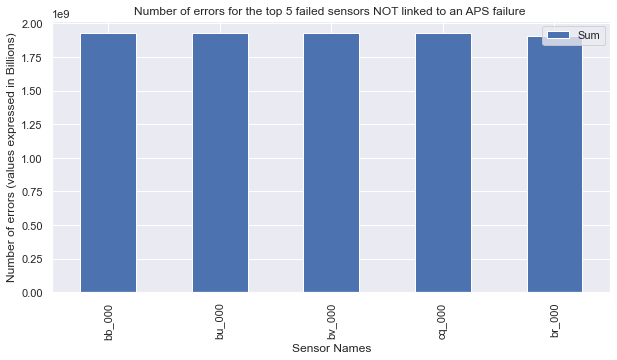

In [63]:
top_not_aps_failures.plot(kind='bar', figsize=(10,5))
plt.title('Number of errors for the top 5 failed sensors NOT linked to an APS failure ')
plt.ylabel('Number of errors (values expressed in Billions)')
plt.xlabel('Sensor Names')

Same as on the previous variable, I selected the top 5 sensors with more errors. My objective is to determine which sensors have  greater sensibility to flag an error when an APS failure happens and which of them when not. Know I'll get the % of total errors flagged by these 5 sensors. 

In [64]:
sum = top_not_aps_failures.sum()
sum.name = 'sum'
not_aps_failures = not_aps_failures.append(sum.transpose()) #add a total value row

not_aps_failures=not_aps_failures.transpose()

total_errors = not_aps_failures['sum'].sum()

total_errors=str(total_errors)

<ipython-input-64-391cd9d70ad7>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  not_aps_failures = not_aps_failures.append(sum.transpose()) #add a total value row


In [65]:
print('There are a total of ' + total_errors + ' errors')

There are a total of 9605012236.0 errors


In [66]:
total_errors=float(total_errors)

top_not_aps_failures
top_not_aps_failures=top_not_aps_failures.rename(columns={'Sum':'number_of_errors'})
top_not_aps_failures['%_of_total_errors'] = (top_not_aps_failures['number_of_errors'] / total_errors) * 100

In [67]:
top_not_aps_failures

,number_of_errors,%_of_total_errors
bb_000,1.924570e+09,20.037147
bu_000,1.924570e+09,20.037146
bv_000,1.924570e+09,20.037146
cq_000,1.924570e+09,20.037146
br_000,1.906731e+09,19.851414


In [68]:
top_not_sensors_errors_per = top_not_aps_failures['%_of_total_errors'].sum()
top_not_sensors_errors_per=str(round(top_not_sensors_errors_per,3))
print (top_not_sensors_errors_per + '% of errors are flagged by the top 5 sensors')

100.0% of errors are flagged by the top 5 sensors


##### Conclusions for the NOT APS related failures

    - From the 6000 analyzed trucks, only 98% of them had an APS related failure
    - 60 out of 170 were considered failed sensors because 20% or more than their results were null (35%)
    - After cleaning and normalizing the data 1484 rows were tooked into account which reduces the sample by a lot but makes             our data more reliable.
    - 5 sensors flag 100% of the errors for trucks with a known NOT APS related failure

https://sparkbyexamples.com/pandas/pandas-sum-dataframe-columns/#:~:text=To%20calculate%20the%20sum%20of%20the%20given%20column%20or%20a,to%20get%20the%20total%20sum.

https://stackoverflow.com/questions/38733477/whats-the-best-way-to-sum-all-values-in-a-pandas-dataframe

https://stackoverflow.com/questions/42865805/add-a-row-with-means-of-columns-to-pandas-dataframe

https://pandas.pydata.org/docs/user_guide/index.html